In [1]:
import tensorflow as tf
from utils.modelLoader import ModelLoader
import pandas as pd
from utils.utilities import buildRunName
import numpy as np


In [6]:
@tf.function
def decode_img(img_path):
    """
    function read image from filepath and format it into a tensor
    :param img_path: filepath of the image
    :return: decodes image as tensor
    """
    image_size = (224, 224)
    num_channels = 3
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    img = tf.image.resize(img, image_size, method="bilinear")
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

def process_path(file_path, labels):
    label = {'out_age_prediction': tf.reshape(tf.keras.backend.cast(labels[0], tf.keras.backend.floatx()), (1, 1)),
             'out_face_detection': tf.reshape(tf.keras.backend.cast(labels[1], tf.keras.backend.floatx()), (1, 1)),
             'out_mask_detection': tf.reshape(tf.keras.backend.cast(labels[2], tf.keras.backend.floatx()), (1, 1))}
    img = decode_img(file_path)
    return img, label

def group_ages(age: int):
    current_range = [
        ( 0, 0),
        ( 1,10),
        (11,20),
        (21,30),
        (31,40),
        (41,50),
        (51,60),
        (61,70),
        (71,80),
        (81,90),
        (91,100)
    ]
    if isinstance(age, int) and age >= current_range[0] and age <= current_range[1]:
        return current_range.index(current_range)
    else:
        return age

def create_dataset(data):
    data = tf.data.Dataset.from_tensor_slices(
        (data["Filepath"], data[["Age", "Face", "Mask"]]))
    ds = data.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


metaData = pd.read_json("../data_meta/meta_all.json")
metaData = metaData.sample(frac=1, random_state=123).reset_index(drop=True)
metaData_train = metaData.iloc[0:int(metaData.__len__() * 0.7)]
metaData_val =  metaData.iloc[int(metaData.__len__() * 0.7)+1:int(metaData.__len__() * 0.85)]
metaData_test = metaData.iloc[int(metaData.__len__() * 0.85)+1:]

train_ds = create_dataset(metaData_train)
val_ds = create_dataset(metaData_val)
test_ds = create_dataset(metaData_test)

model = ModelLoader().loadMobileNetV1Multi(10, ageDropout=0.1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "out_age_prediction": tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=-1),
        "out_face_detection": tf.keras.losses.BinaryCrossentropy(),
        "out_mask_detection": tf.keras.losses.BinaryCrossentropy(),
    },
    loss_weights={
        "out_age_prediction": 0.33,
        "out_face_detection": 0.33,
        "out_mask_detection": 0.33,
    },
    metrics={
        "out_age_prediction": tf.keras.metrics.SparseCategoricalAccuracy(),
        "out_face_detection": tf.keras.metrics.BinaryAccuracy(),
        "out_mask_detection": tf.keras.metrics.BinaryAccuracy(),
    },
)


log_dir = "../logs/fit/" + buildRunName("MobileNet_MultiTask_Dropout-10", 50, 32)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[tensorboard_callback]
)

model.save("../models/" + buildRunName("MobileNet_MultiTask_Dropout-10", 50, 32))

Epoch 1/50
866/866 [==============================] - 65s 72ms/step - loss: 0.5205 - out_face_detection_loss: 0.0364 - out_mask_detection_loss: 0.0280 - out_age_prediction_loss: 1.5128 - out_face_detection_binary_accuracy: 0.9893 - out_mask_detection_binary_accuracy: 0.9911 - out_age_prediction_sparse_categorical_accuracy: 0.2312 - val_loss: 0.4620 - val_out_face_detection_loss: 0.0067 - val_out_mask_detection_loss: 0.0158 - val_out_age_prediction_loss: 1.3776 - val_out_face_detection_binary_accuracy: 0.9985 - val_out_mask_detection_binary_accuracy: 0.9949 - val_out_age_prediction_sparse_categorical_accuracy: 0.2615
Epoch 2/50
866/866 [==============================] - 61s 70ms/step - loss: 0.4523 - out_face_detection_loss: 0.0064 - out_mask_detection_loss: 0.0125 - out_age_prediction_loss: 1.3517 - out_face_detection_binary_accuracy: 0.9987 - out_mask_detection_binary_accuracy: 0.9960 - out_age_prediction_sparse_categorical_accuracy: 0.2541 - val_loss: 0.4455 - val_out_face_detection_

INFO:tensorflow:Assets written to: ../models/MobileNet_MultiTask_Dropout-10_epochs-50_batch-32\assets


INFO:tensorflow:Assets written to: ../models/MobileNet_MultiTask_Dropout-10_epochs-50_batch-32\assets


In [10]:
model.evaluate(test_ds)

In [8]:
metaData_age = pd.read_json("../data_meta/meta_all_onlyAge.json")
metaData_age = metaData_age.sample(frac=1, random_state=123).reset_index(drop=True)

test_age_ds = create_dataset(metaData_age)

In [9]:
model.evaluate(test_age_ds)

672/672 [==============================] - 35s 52ms/step - loss: 0.4758 - out_face_detection_loss: 0.0017 - out_mask_detection_loss: 0.0013 - out_age_prediction_loss: 1.4389 - out_face_detection_binary_accuracy: 0.9996 - out_mask_detection_binary_accuracy: 0.9997 - out_age_prediction_sparse_categorical_accuracy: 0.6577


[0.475816935300827,
 0.0016594651388004422,
 0.0013235326623544097,
 1.438886284828186,
 0.9995808601379395,
 0.9996740221977234,
 0.657663106918335]

In [2]:
model = tf.keras.models.load_model("../models/MobileNet_MultiTask_epochs-50_batch-32/")

In [6]:
image = tf.io.read_file("../data/age/54_0_3_20170119210218868.jpg")
image = tf.image.decode_image(image, channels=3)
image = np.expand_dims(image.numpy(), axis=0)
image = tf.image.resize(image, (224,224))
res = model.predict(image)

1/1 [==============================] - 0s 24ms/step


[array([[1.]], dtype=float32),
 array([[3.1993606e-33]], dtype=float32),
 array([[5.4988116e-09, 2.1761896e-06, 3.1742651e-02, 4.1475534e-01,
         8.1409581e-02, 4.7154027e-01, 5.4972689e-04, 2.6531927e-07,
         2.9987027e-10, 2.9696237e-17]], dtype=float32)]

In [11]:
metaDataAge = pd.read_json("../data_meta/meta_all_onlyAge.json")

actVals = list()
predVals = list()

for index, imageMataData in metaDataAge.iterrows():
    image = tf.io.read_file(imageMataData["Filepath"])
    image = tf.image.decode_image(image, channels=3)
    image = np.expand_dims(image.numpy(), axis=0)
    image = tf.image.resize(image, (224,224))
    _,_,predAge = model.predict(image)
    predVals.append(np.argmax(predAge))
    actVals.append(imageMataData["Age"])

1/1 [==============================] - 0s 30ms/step


In [15]:
predValsTemp = [int(x) for x in actVals]

import json
file = open("tempdump2.json", "w")
temp = json.dumps(predValsTemp)
file.write(temp)
file.close()

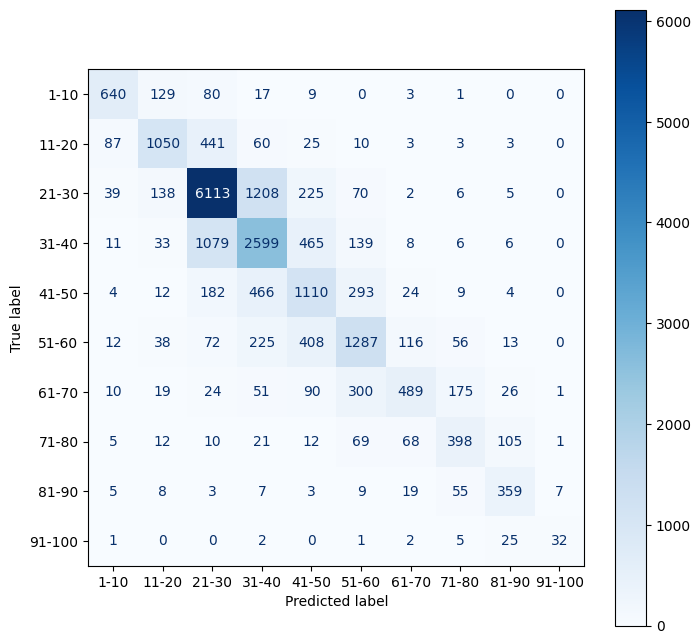

In [26]:
from sklearn import metrics
import matplotlib as plt

confusion_matrix = metrics.confusion_matrix(actVals, predVals)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
cm_display.plot(cmap="Blues")
cm_display.figure_.set_size_inches([8, 8])